In [1]:
# from astroquery.gaia import Gaia
from astropy import units as u
from astropy.coordinates import SkyCoord
from sklearn.neighbors import NearestNeighbors
import scipy as sp
from scipy.spatial import distance
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import mpl_scatter_density
from matplotlib.colors import LinearSegmentedColormap
from scipy.optimize import curve_fit
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize, StandardScaler
import scienceplots
import networkx as nx
# import mplcursors


import warnings
warnings.filterwarnings('ignore')

## Functions

In [2]:
def min_span_tree(df_data, params, num_std = 1, manual_th=True, threshold=.85, y_limit=5, fig=True):

    np.random.seed(101)

    df_data = df_data.reset_index().drop('index', axis=1)
    data = df_data.copy()
    scaler = StandardScaler()
    data[params] = scaler.fit_transform(data[params])

    nn = NearestNeighbors(n_neighbors=3, metric='minkowski')
    nn.fit(data[params])
    distances, indices = nn.kneighbors(data[params])

    # Create an empty graph
    G = nx.Graph()

    # Add edges with distances to the graph
    n_samples = data.shape[0]
    for i in range(n_samples):
        for j in range(1, len(indices[i])):
            neighbor_index = indices[i, j]
            weight = distances[i, j]
            G.add_edge(i, neighbor_index, weight=weight)

    # Compute the minimum spanning tree
    mst = nx.minimum_spanning_tree(G)

    # Weight of the MST
    edge_weights = [X['weight'] for _, _, X in mst.edges(data=True)]

    if not manual_th: # use threshold to filter
        threshold = np.mean(edge_weights) + num_std * np.std(edge_weights)
        print('threshold:', round(threshold, 2))

    if fig:
        # Sort the edge weights in ascending order
        sorted_weights = sorted(edge_weights)

        # Plot sorted edge weights
        plt.figure(figsize=(4,2))
        plt.plot(sorted_weights)
        plt.hlines(threshold, 0,len(df_data), colors='red')
        plt.ylim(0, y_limit)
        plt.xlabel('Edge Index')
        plt.ylabel('Edge Weight')
        plt.title('Sorted Edge Weights')
        plt.show()

    # Identify the nodes with weights greater than the mean weight
    nodes_to_remove = [node for node in mst.nodes() if mst.degree(node, weight='weight') > threshold]

    # Remove the identified nodes from the MST
    mst.remove_nodes_from(nodes_to_remove)

    df_data['MST_cluster'] = 1
    df_data.loc[nodes_to_remove, 'MST_cluster'] = 0

    return df_data


def preprocess_cluster(data, g_mean_th=19):
    """
    ------
    parallax > 0

    phot_g_mean_mag < g_mean_th
    ------
    """
    data = data[data['parallax'] > 0]
    data = data[data['phot_g_mean_mag'] < g_mean_th]
    data['Gmg'] = data['phot_g_mean_mag'] + (5 * np.log10(data['parallax']) - 10)
    data['L'] = 10**(0.4*(4.83 - data['Gmg']))
    data = data[(abs(data['pmra']) < 10) & (abs(data['pmdec']) < 10)]
    print(len(data))
    return data


def cmd_plot(data, x_axis, y_axis, alpha=0.8, s=5):
    """
    -------
    plot isochrone
    -------
    """

    fig = plt.figure(figsize=(6,4), dpi=100)
    sns.scatterplot(data=data, y=y_axis, x=x_axis, alpha=alpha, s=s, color='black')
    plt.gca().invert_yaxis();


def joint_plot(data):

    plt.figure(dpi=90)
    sns.jointplot(
        data=data,
        x="pmra", y="pmdec",
        kind="kde"
        )
    plt.show()


def fit_curve(data, column, bins = 100):

    plt.figure(figsize=(8,2), dpi=80)
    counts, bins, patches = plt.hist(data[column], bins = bins)

    # Define the Gaussian function
    def gaussian(x, amp, mu, sigma):
        return amp * np.exp(-(x - mu)**2 / (2 * sigma**2))

    # data
    x_data = bins[:-1]
    y_data = counts

    # Fit the Gaussian function to the data
    popt, pcov = curve_fit(gaussian, x_data, y_data, maxfev=5000)

    plt.figure(figsize=(8,2), dpi=80)
    # Plot the original data and the fitted curve
    sns.scatterplot(x=x_data, y=y_data, label=column)
    plt.plot(x_data, gaussian(x_data, *popt), color='red', label='Fit')
    plt.legend()
    plt.show()

    return popt


def guassian_filter(data, column, mu, std):
    up = round(mu + 3 * std, 2)
    low = round(mu - 3 * std, 2)

    if up > low:
        print(f'{column} upper bound:', up)
        print(f'{column} lower bound:', low)
        df = data[(data[column] < up) & (data[column] > low)]
    else:
        print(f'{column} upper bound:', low)
        print(f'{column} lower bound:', up)
        df = data[(data[column]< low) & (data[column] > up)]

    print('cluster length:', len(df))
    return df


def luminosity_density(cluster_3d, clusterdf):
    """
    --------
    cluster_3d --> measuring distance in that dataframe

    clusterdf --> main dataframe
    -------
    """
    # create a NearestNeighbors object and fit the dataset
    nbrs = NearestNeighbors(n_neighbors=6, metric='minkowski').fit(cluster_3d)

    # find the 5 nearest neighbors for each data point including itself
    distances, indices = nbrs.kneighbors(cluster_3d)

    # find maximum distance among 5 neighbors
    max_distances = np.amax(distances, axis=1)

    # sphere of that max distance
    spheres = (4/3) * np.pi * (max_distances ** 3)

    # sum of luminosities of each 6 nn
    lum_sum = []
    for i in range(len(clusterdf)):
        lum_sum.append(np.sum(clusterdf.iloc[indices[i]]['L']))

    # luminosity density
    lum_dens = lum_sum / spheres

    return lum_dens



def lum_plot(data):
    """
    --------
    plot for luminosity density profile
    --------
    """

    plt.figure(figsize=(12,6), dpi=200)
    plt.plot(range(len(data)), np.sort(data))
    plt.ylabel('ΔL/ΔV')
    plt.title('luminosity density profile');


def cmd_plotly(data, x_axis, y_axis, huex = 'cluster', ax=None, alpha=0.8, s=7, theme=None):
    """
    -------
    plot isochrone
    -------
    """
    with plt.style.context(['ieee']):
        if ax is None:
            fig = plt.figure(figsize=(5,4), dpi=100)
            ax = fig.add_subplot(111)
        sns.scatterplot(data=data, y=y_axis, x=x_axis, alpha=alpha, s=s, hue = huex, ax=ax, palette=theme)
        ax.invert_yaxis()

In [3]:
df_NGC_2099  = pd.read_csv('./data/NGC 2099-result.csv')

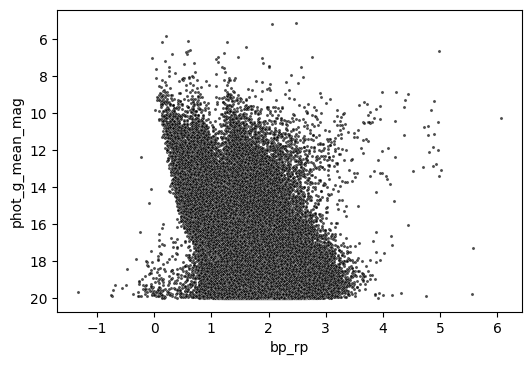

In [4]:
cmd_plot(data=df_NGC_2099, x_axis='bp_rp', y_axis='phot_g_mean_mag', s=5, alpha=.7)

In [4]:
df_NGC_2099_new = df_NGC_2099.drop(['ra_error', 'dec_error', 'parallax_error', 'pmra_error', 'pmdec_error', 'ruwe',
       'radial_velocity', 'rv_template_fe_h', 'non_single_star', 'has_epoch_rv',
       'phot_variable_flag', 'l', 'b', 'teff_gspphot', 'distance_gspphot', 'r_med_geo', 'r_med_photogeo',
       'azero_gspphot', 'ag_gspphot', 'ebpminrp_gspphot', 'source_id.1'], axis=1).dropna(axis=0)

In [5]:
df_NGC_2099_new.columns

Index(['source_id', 'ra', 'dec', 'parallax', 'pmra', 'pmdec',
       'phot_g_mean_mag', 'bp_rp', 'bp_g', 'g_rp'],
      dtype='object')

In [6]:
len(df_NGC_2099_new)

526909

----

# MST Method

### 1. Initial Filters on Data

In [48]:
df_NGC_2099_new = df_NGC_2099.drop(['ra_error', 'dec_error', 'parallax_error', 'pmra_error', 'pmdec_error', 'ruwe',
       'radial_velocity', 'rv_template_fe_h', 'non_single_star', 'has_epoch_rv',
       'phot_variable_flag', 'l', 'b', 'teff_gspphot', 'distance_gspphot', 'r_med_geo', 'r_med_photogeo',
       'azero_gspphot', 'ag_gspphot', 'ebpminrp_gspphot', 'source_id.1'], axis=1).dropna(axis=0)

In [49]:
# Initial Filter on PMRA and PMDEC 

def filter_proper_motion(data, pmra, pmdec, d_pmra=2, d_pmdec=2):
    return data[(abs(data['pmra'] - pmra) < d_pmra) & (abs(data['pmdec'] - pmdec) < d_pmdec)]

def filter_parallax(data, parallax, delta = .2):
    return data[(abs(data['parallax'] - parallax) < delta)]

# def filter_distance(data, r_med, delta = 100):
#     return data[(abs(data['r_med_geo'] - r_med) < delta)] # r_med_geo

In [50]:
df_NGC_2099_new = filter_proper_motion(df_NGC_2099_new, 1.924, -5.648, .8, .8)
df_NGC_2099_new = filter_parallax(df_NGC_2099_new, 0.666, 0.2)

In [51]:
len(df_NGC_2099_new)

5376

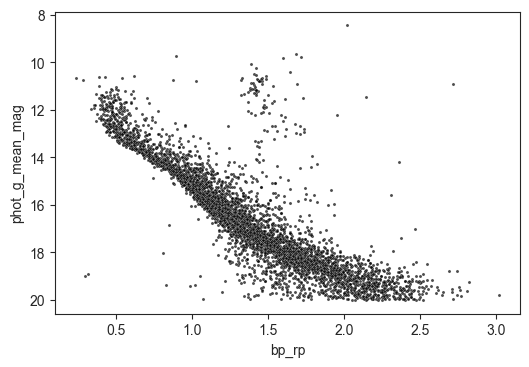

In [52]:
cmd_plot(data = df_NGC_2099_new, x_axis = 'bp_rp', y_axis = 'phot_g_mean_mag', s = 5, alpha = .7)

In [53]:
### Gaussian Filters

def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj] # print name of variable

def guassian_fit_filter(data, parameter, num_bins=80):
    print('\n',namestr(data, globals())[0])
    amp, mu, std = fit_curve(data, parameter, bins=num_bins)
    return guassian_filter(data, parameter, mu, std)

In [54]:
sns.set_style('ticks')


 df_NGC_2099_new


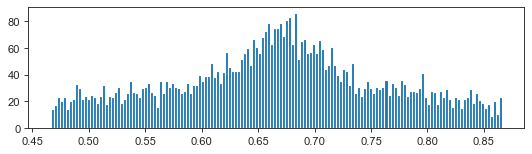

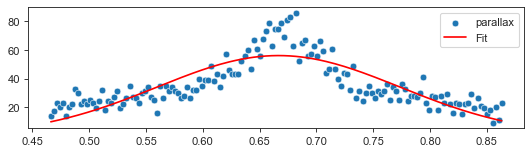

parallax upper bound: 0.99
parallax lower bound: 0.35
cluster length: 5376

 df_NGC_2099_new


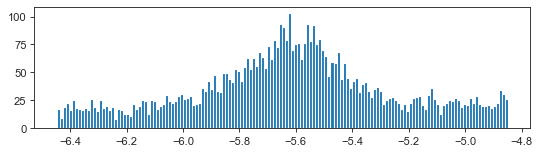

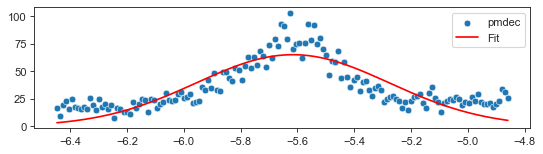

pmdec upper bound: -4.6
pmdec lower bound: -6.64
cluster length: 5376

 df_NGC_2099_new


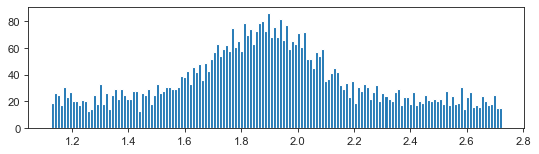

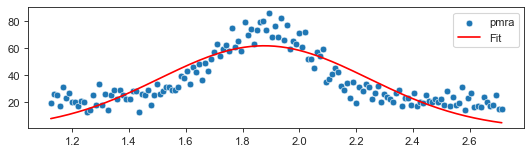

pmra upper bound: 2.98
pmra lower bound: 0.77
cluster length: 5376


In [55]:
df_NGC_2099_new = guassian_fit_filter(df_NGC_2099_new, 'parallax', 150)
df_NGC_2099_new = guassian_fit_filter(df_NGC_2099_new, 'pmdec', 150)
df_NGC_2099_new = guassian_fit_filter(df_NGC_2099_new, 'pmra', 150)

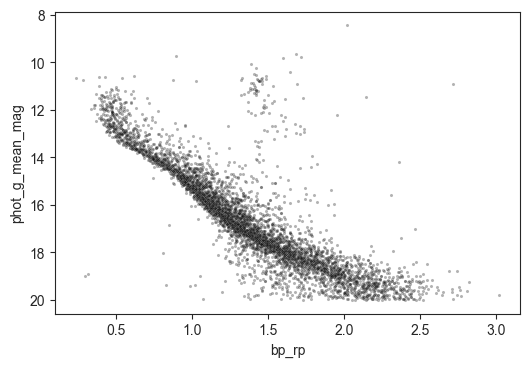

In [56]:
cmd_plot(df_NGC_2099_new, 'bp_rp', 'phot_g_mean_mag', alpha=0.3)

### 2. MST

In [57]:
params = ['ra', 'dec', 'parallax']

In [58]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(df_NGC_2099_new[params])

df_scaled = pd.DataFrame(data=x_scaled, columns=params)
df_scaled['source_id'] = df_NGC_2099_new['source_id'].values

threshold: 0.41


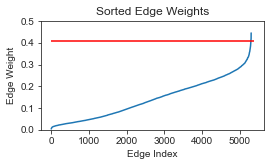

In [59]:
df_scaled = min_span_tree(df_scaled, params=params, num_std=3, manual_th=False, threshold=.3, y_limit=0.5, fig=True)

In [60]:
print(len(df_scaled[df_scaled['MST_cluster']==1]))
print(len(df_scaled[df_scaled['MST_cluster']==0]))

3978
1398


In [61]:
# df_NGC_2099_new = df_NGC_2099_new.drop(["MST_cluster"], axis=1)

In [62]:
df_NGC_2099_new = df_NGC_2099_new.merge(df_scaled[["MST_cluster", "source_id"]], on='source_id', how='left')

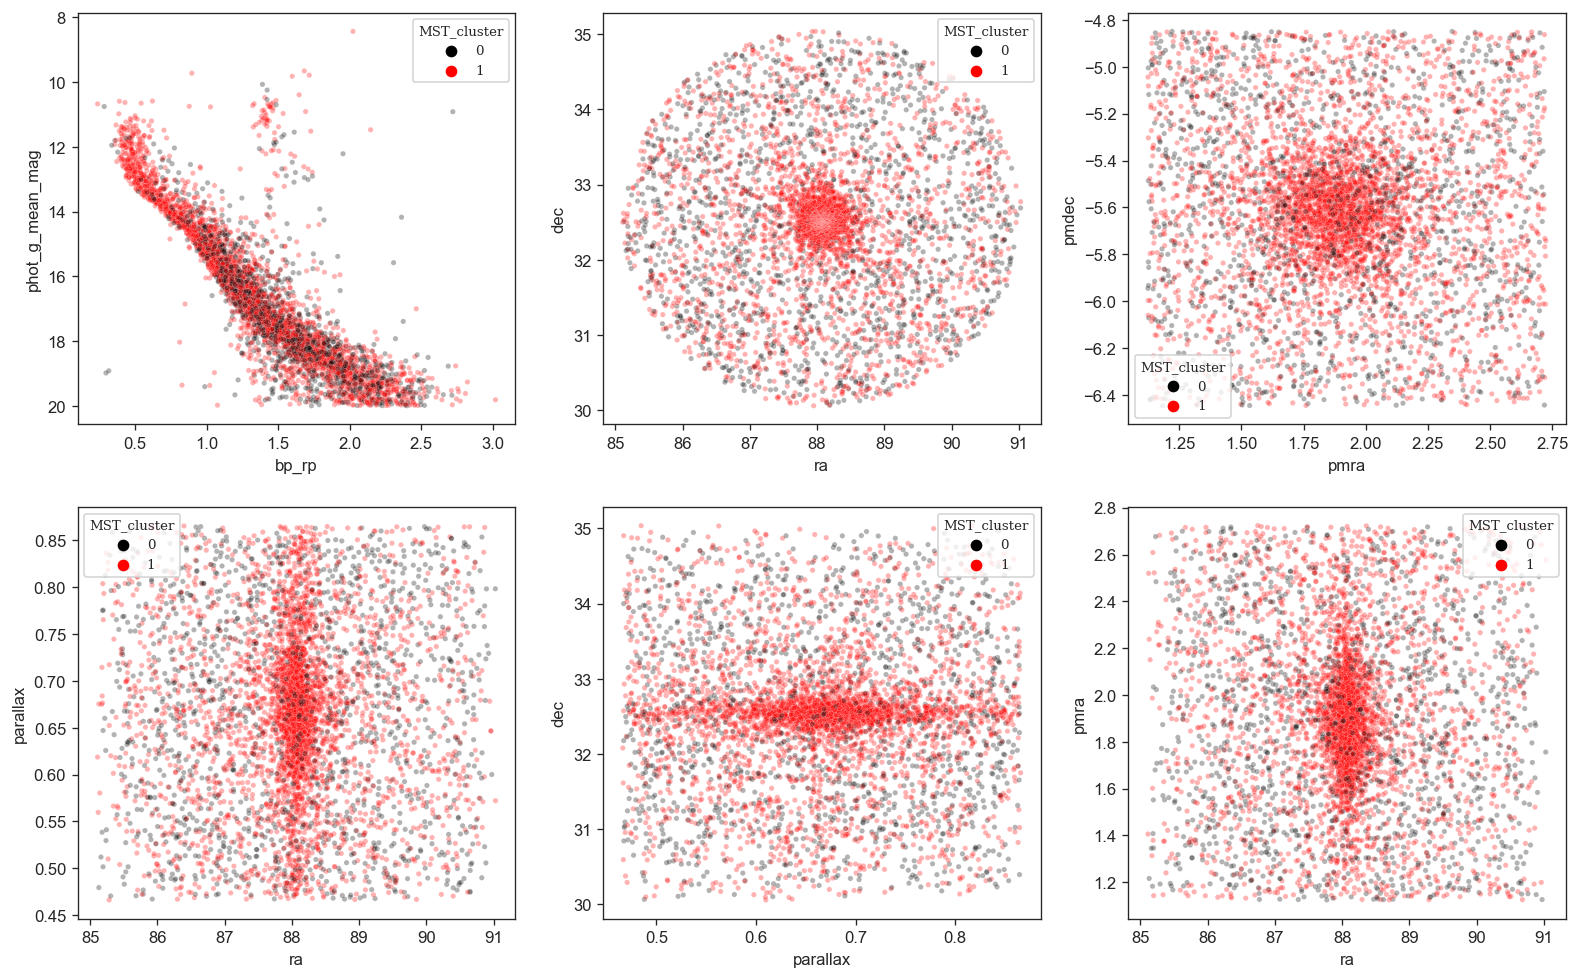

In [63]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10), dpi=120)

cmd_plotly(df_NGC_2099_new, 'bp_rp', 'phot_g_mean_mag', huex='MST_cluster', s=10, alpha=.3,ax=axes[0,0], theme={1:'red', 0:'black'})
cmd_plotly(df_NGC_2099_new, 'ra', 'dec', huex='MST_cluster', s=10, alpha=.3, ax=axes[0,1], theme={1:'red', 0:'black'})
axes[0,1].invert_yaxis()

cmd_plotly(df_NGC_2099_new, 'pmra', 'pmdec', huex='MST_cluster', s=10, alpha=.3, ax=axes[0,2], theme={1:'red', 0:'black'})
axes[0,2].invert_yaxis()
cmd_plotly(df_NGC_2099_new, 'ra', 'pmra', huex='MST_cluster', s=10, alpha=.3, ax=axes[1,2], theme={1:'red', 0:'black'})
axes[1,2].invert_yaxis()

cmd_plotly(df_NGC_2099_new, 'ra', 'parallax', huex='MST_cluster', s=10, alpha=.3, ax=axes[1,0], theme={1:'red', 0:'black'})
axes[1,0].invert_yaxis()
cmd_plotly(df_NGC_2099_new, 'parallax', 'dec', huex='MST_cluster', s=10, alpha=.3, ax=axes[1,1], theme={1:'red', 0:'black'})
axes[1,1].invert_yaxis()

#### Statistical Approach (Finding Outliers)

In [64]:
df_NGC_2099_new = df_NGC_2099_new[df_NGC_2099_new['MST_cluster']==1]
df_NGC_2099_new = df_NGC_2099_new.reset_index()

In [65]:
scaler = StandardScaler()
temp_df = pd.DataFrame()
to_drop = []

temp_df[['parallax', 'ra', 'dec', 'pmra', 'pmdec']] = scaler.fit_transform(
    df_NGC_2099_new[['parallax', 'ra', 'dec', 'pmra', 'pmdec']]
)

for i in ['parallax', 'ra', 'dec', 'pmra', 'pmdec']:
    outliers = temp_df[abs(temp_df[i]) > 3].index
    to_drop.extend(outliers)

df_NGC_2099_new = df_NGC_2099_new.drop(to_drop)

In [66]:
len(df_NGC_2099_new)

3965

### 3. GMM

In [67]:
def gassian_mixture(data, parameters = ['pmra', 'pmdec', 'parallax', 'ra', 'dec']):
    np.random.seed(0)
    
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(data[parameters])
    
    gm = GaussianMixture(n_components=2, random_state=99)

    y_pred = gm.fit_predict(x_scaled)
    y_prob = gm.predict_proba(x_scaled)

    data['gmm_pred'] = y_pred
    data['gmm_prob'] = np.amax(y_prob,axis=1)
    return data, gm

In [68]:
# GMM on MST
df_NGC_2099_cluster, model = gassian_mixture(df_NGC_2099_new)

# Probability
# df_NGC_2099_cluster = df_NGC_2099_cluster[df_NGC_2099_cluster['gmm_prob']>=.8]

In [69]:
df_NGC_2099_cluster.gmm_pred.value_counts()

1    2073
0    1892
Name: gmm_pred, dtype: int64

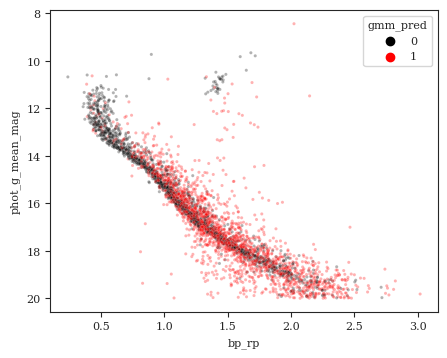

In [70]:
cmd_plotly(df_NGC_2099_cluster, 
           'bp_rp', 'phot_g_mean_mag', huex='gmm_pred', s=5, alpha=0.3)

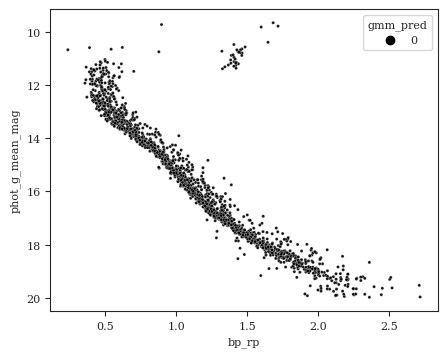

In [71]:
cmd_plotly(df_NGC_2099_cluster[df_NGC_2099_cluster['gmm_pred']==0], 
           'bp_rp', 'phot_g_mean_mag', huex='gmm_pred', s=5, alpha=.9)

In [72]:
### cluster stars

len(df_NGC_2099_cluster[(df_NGC_2099_cluster['gmm_pred']==0)])

1892

In [73]:
### high probable stars
len(df_NGC_2099_cluster[(df_NGC_2099_cluster['gmm_pred']==0) & (df_NGC_2099_cluster['gmm_prob']>=0.8)])

1746

## Evaluation

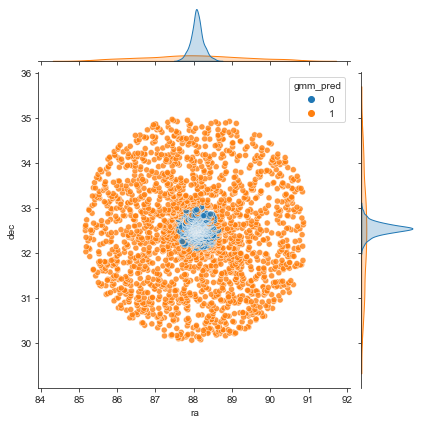

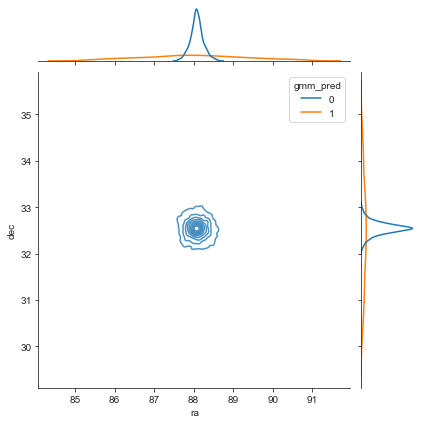

In [74]:
sns.jointplot(data=df_NGC_2099_cluster, x='ra', y='dec', kind='scatter', hue='gmm_pred', alpha=.8)
sns.jointplot(data=df_NGC_2099_cluster, x='ra', y='dec', kind='kde', hue='gmm_pred', alpha=.8);

In [75]:
def black_body_plot(data, x_axis, y_axis, ax=None, alpha=0.8, s=8):
    
    with plt.style.context(['ieee']):
        if ax is None:
#             fig = plt.figure(figsize=(4,4), dpi=100)
            ax = fig.add_subplot(111)
        sns.scatterplot(data=data, y=y_axis, x=x_axis, alpha=alpha, s=s, ax=ax, color='black')
        ax.invert_xaxis()

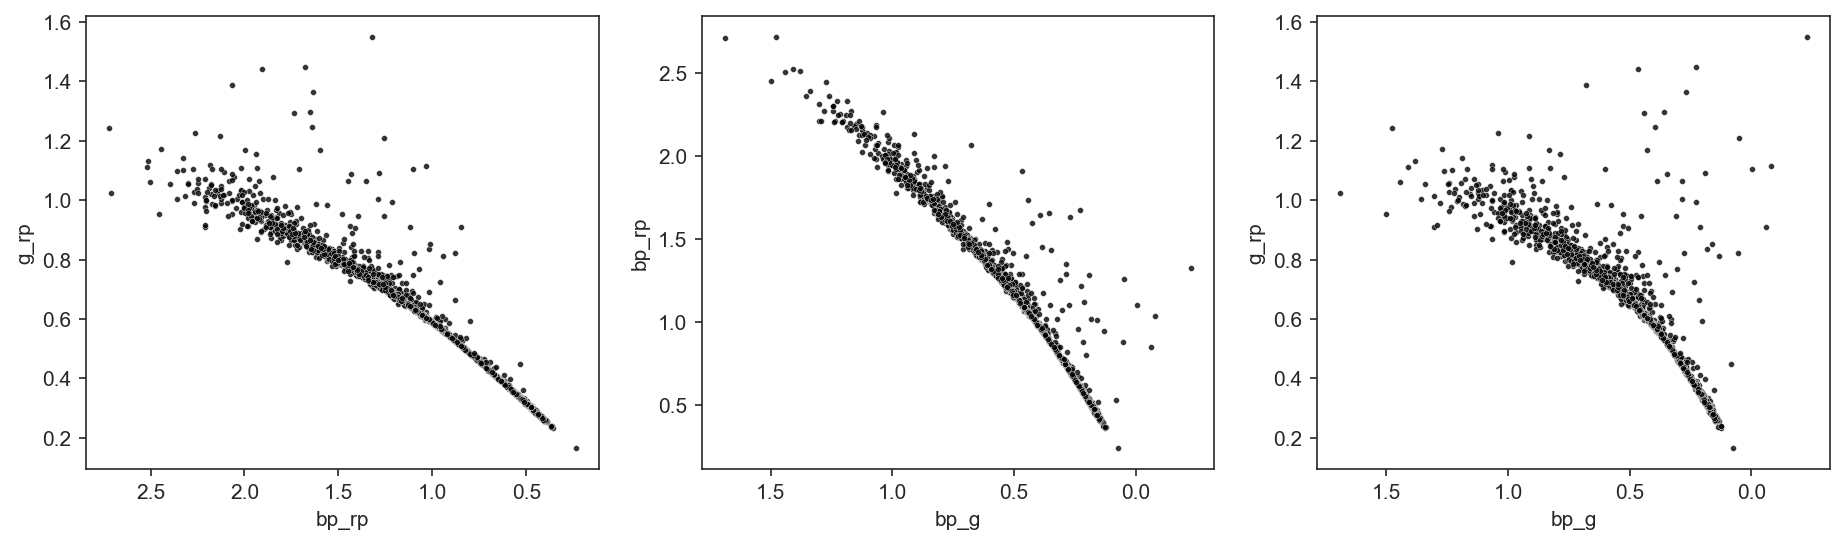

In [76]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), dpi=150)
black_body_plot(df_NGC_2099_cluster[(df_NGC_2099_cluster['gmm_pred']==0)], 'bp_rp', 'g_rp', ax=axes[0])
# black_body_plot(stars, 'bp_rp', 'g_rp', ax=axes[0], s=50)

black_body_plot(df_NGC_2099_cluster[(df_NGC_2099_cluster['gmm_pred']==0)], 'bp_g', 'bp_rp', ax=axes[1])
# black_body_plot(stars, 'bp_rp', 'g_rp', ax=axes[1], s=50)

black_body_plot(df_NGC_2099_cluster[(df_NGC_2099_cluster['gmm_pred']==0)], 'bp_g', 'g_rp', ax=axes[2])
# black_body_plot(stars, 'bp_rp', 'g_rp', ax=axes[2], s=50)

#### King Profile

In [77]:
cluster = df_NGC_2099_cluster[(df_NGC_2099_cluster['gmm_pred']==0)]

In [78]:
np.mean(cluster['ra']), \
np.mean(cluster['dec'])

(88.08234190325561, 32.54099058869249)

In [79]:
def king_profile_function(x, f_b, f_0, R_c):
    return (f_b + (f_0 / (1 + (x/R_c)**2)))

def fit_king_profile(data, plotting = True, norm_density=False, radius_num = 13):
    """
    returns coefs: [f_b, f_0, R_c], R_t
    """

    center = (np.mean(data['ra']), np.mean(data['dec']))  #  center of cluster     
    max_r = round(max(np.linalg.norm(center - data[['ra', 'dec']], axis=1)), 2) + 0.01 

    radii = np.linspace(0, max_r, radius_num)  # Define the radii of the concentric circles
    x = np.linspace(0, max_r, num=100)

    # star density
    star_densities = []
    for i in range(radius_num - 1):
        r_inner = radii[i]
        r_outer = radii[i + 1]

        # Calculate the distances between the center and each star's position
        distances = np.sqrt(
            (data['ra'] - center[0])**2 + (data['dec'] - center[1])**2
        )

        # Count the number of stars within the current circle
        stars_within_circle = data[(distances >= r_inner) & (distances < r_outer)]
        star_count = len(stars_within_circle)

        # Calculate the area of the circle
        circle_area = np.pi * (r_outer**2 - r_inner**2)

        # Calculate the star density within the circle
        star_density = star_count / circle_area
        star_densities.append(star_density)

    star_densities = np.array(star_densities)

    # normal density
    normal_densities = star_densities / np.linalg.norm(star_densities)

    if norm_density:
        star_densities = normal_densities

    # fitting data on king profile
    coefs, cov = curve_fit(king_profile_function, radii[:-1], star_densities, maxfev=5000, bounds=[0, np.inf])

    R_tidal = coefs[2]*np.sqrt(coefs[1]/(3*np.sqrt(cov[0,0]))-1)

    if plotting:
        with plt.style.context(['science','ieee', 'no-latex']):
            # Plotting the density profile
            plt.figure(figsize=(5, 3), dpi=150)
            plt.plot(radii[:-1], star_densities, 'o', ms=2, color='black')
            plt.plot(x, king_profile_function(x, coefs[0], coefs[1], coefs[2]), '--', color='red', lw=1.7)
            plt.xlabel('Radius from Center (pc)')
            plt.ylabel('Star Density (stars/pc\u00b2)')
#             plt.savefig('king_profile.jpg')
            plt.show()

    return coefs, R_tidal, cov

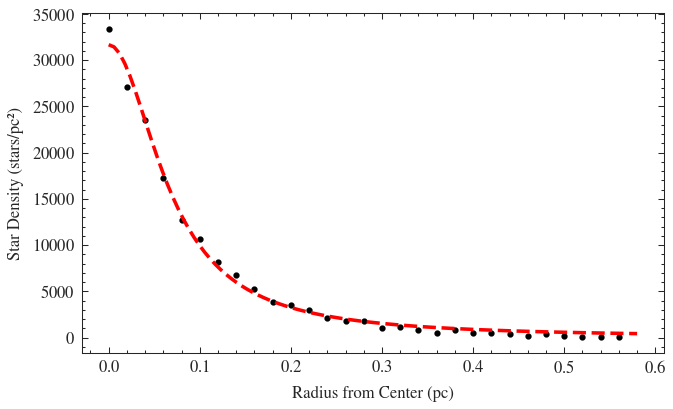

NGC 2099
f_b: 0.0 std: 187.23
f_0: 31672.16
R_c: 0.07
R_t: 0.5


In [80]:
coefs, R_t, cov = fit_king_profile(cluster, norm_density=False, radius_num= 30)

print('NGC 2099')
print("f_b:", round(coefs[0], 2), 'std:', round(np.sqrt(cov[0][0]), 2))
print("f_0:", round(coefs[1], 2))
print("R_c:", round(coefs[2], 2))
print('R_t:', round(R_t, 2))

In [81]:
print('Err Rc:',np.sqrt(cov[2, 2]))
print('Err Rt:',(coefs[2] + np.sqrt(cov[2, 2]))*np.sqrt(coefs[1]/(3*np.sqrt(cov[0,0]))-1))

Err Rc: 0.002029168611789409
Err Rt: 0.5178847760629683


In [82]:
center = (np.mean(cluster['ra']), np.mean(cluster['dec']))
distances = np.sqrt((cluster['ra'] - center[0])**2 + (cluster['dec'] - center[1])**2)
stars_within_core = cluster[(distances < coefs[2])]
stars_out_of_bound = cluster[(distances > R_t)]

In [83]:
len(stars_out_of_bound)

15

In [84]:
len(stars_within_core)

353

In [85]:
# df_NGC_2099.columns

In [86]:
df_NGC_2099_cluster = df_NGC_2099_cluster.merge(df_NGC_2099[["source_id", "r_med_geo"]], on='source_id', how='left').drop("index", axis=1)

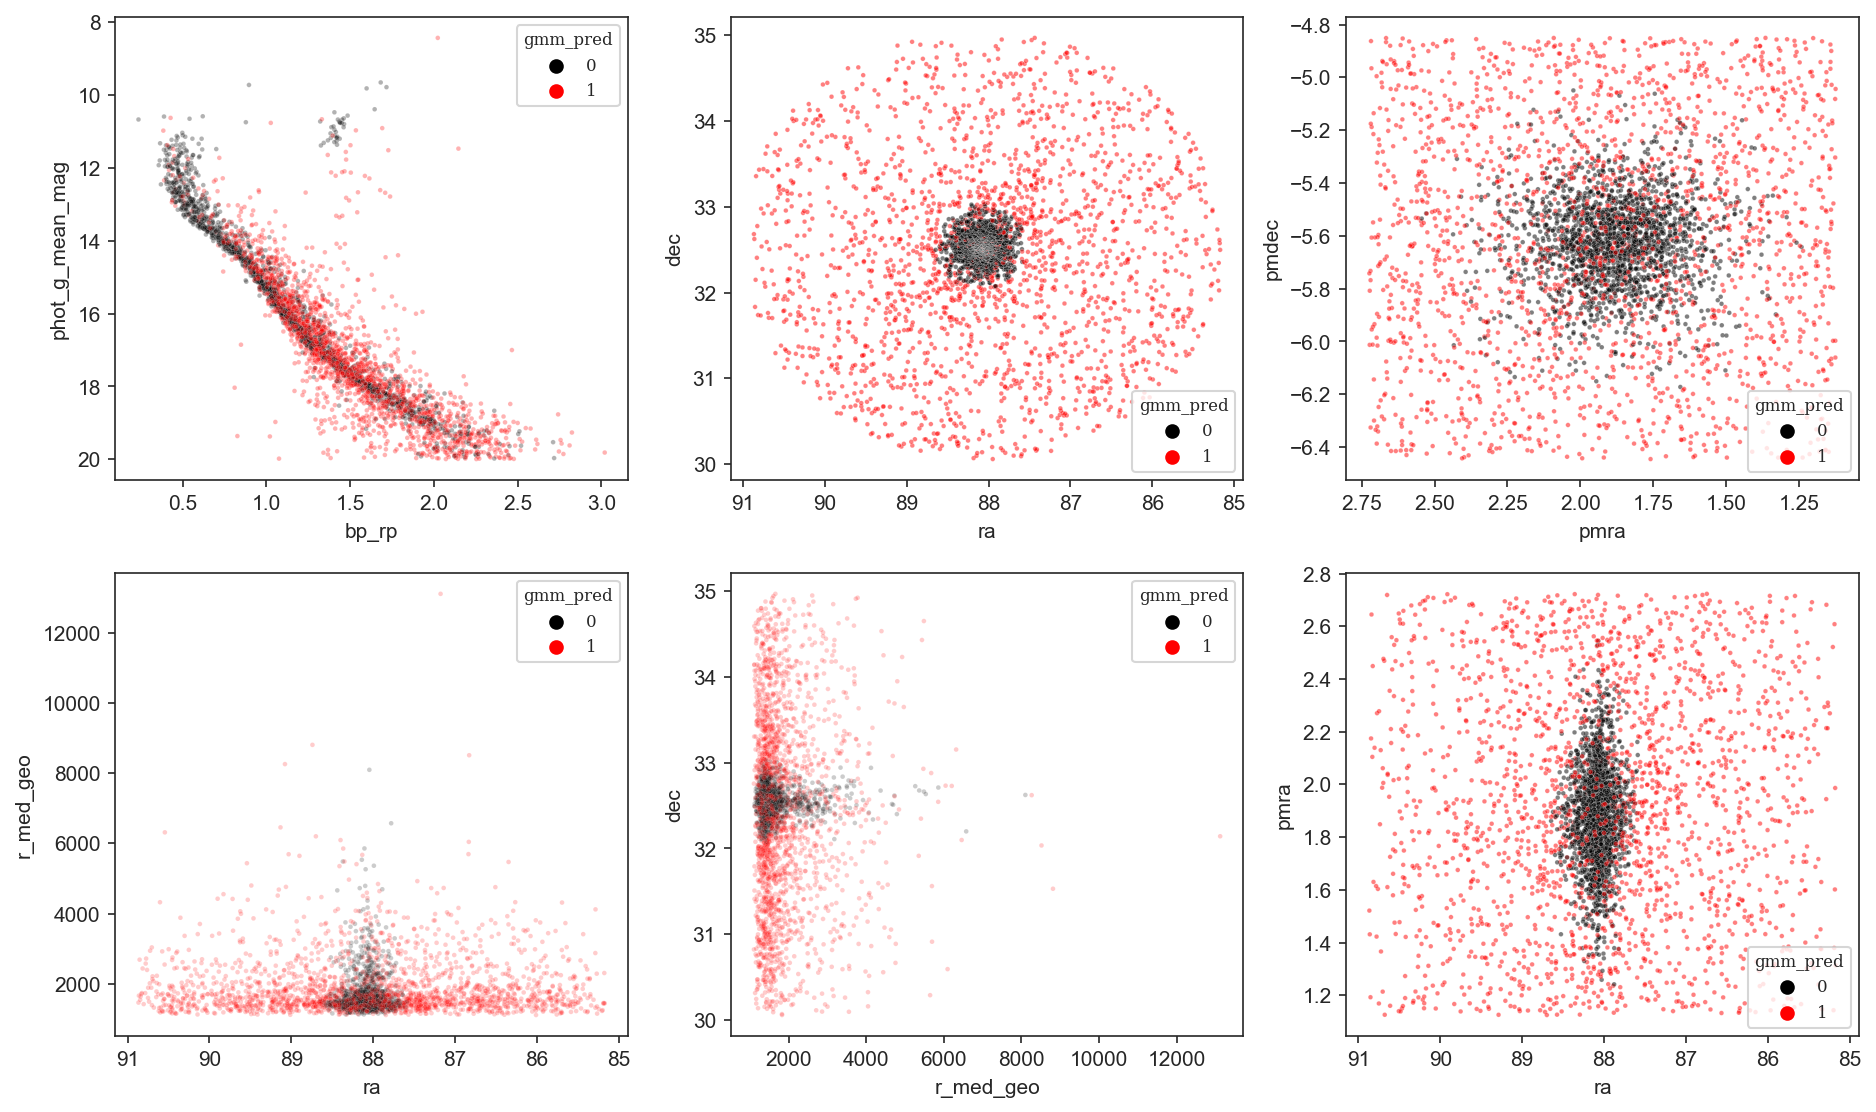

In [87]:
### PLOT THE CLUSTERS

fig, axes = plt.subplots(2, 3, figsize=(15, 9), dpi=150)

cmd_plotly(df_NGC_2099_cluster, 'bp_rp', 'phot_g_mean_mag', huex='gmm_pred', s=5, alpha=.3, ax=axes[0,0])
cmd_plotly(df_NGC_2099_cluster, 'ra', 'dec', huex='gmm_pred', s=5, alpha=.5, ax=axes[0,1])
axes[0,1].invert_yaxis()
axes[0,1].invert_xaxis()
cmd_plotly(df_NGC_2099_cluster, 'ra', 'r_med_geo', huex='gmm_pred', s=5, alpha=.2, ax=axes[1,0])
axes[1,0].invert_yaxis()
axes[1,0].invert_xaxis()
cmd_plotly(df_NGC_2099_cluster, 'r_med_geo', 'dec', huex='gmm_pred', s=5, alpha=.2, ax=axes[1,1])
axes[1,1].invert_yaxis()
cmd_plotly(df_NGC_2099_cluster, 'pmra', 'pmdec', huex='gmm_pred', s=5, alpha=.5, ax=axes[0,2])
axes[0,2].invert_yaxis()
axes[0,2].invert_xaxis()
cmd_plotly(df_NGC_2099_cluster, 'ra', 'pmra', huex='gmm_pred', s=5, alpha=.5, ax=axes[1,2])
axes[1,2].invert_xaxis()
axes[1,2].invert_yaxis()

In [88]:
len(cluster[cluster["gmm_prob"]>=0.8])

1746

In [89]:
len(cluster[cluster["gmm_prob"]>=0.6])

1847

In [90]:
len(cluster)

1892

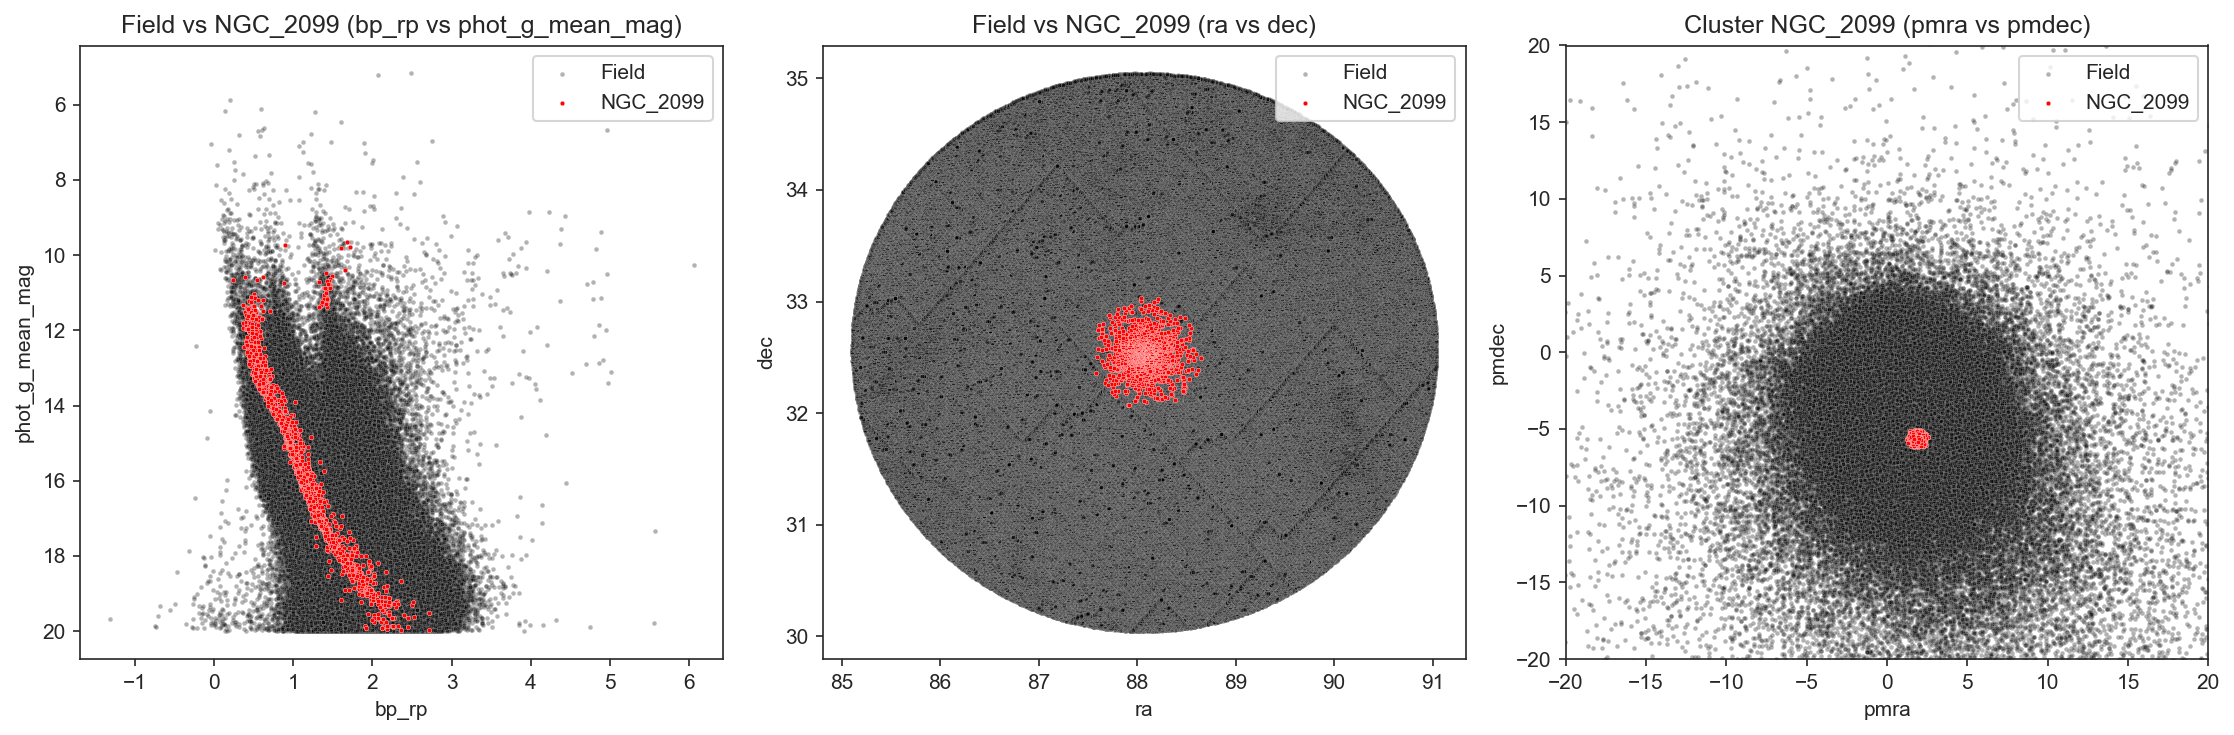

In [95]:
# Create a figure with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=150)

# First subplot: bp_rp vs phot_g_mean_mag
sns.scatterplot(data=df_NGC_2099, x='bp_rp', y='phot_g_mean_mag', s=5, alpha=.3, color="black", label="Field", ax=axes[0])
sns.scatterplot(data=df_NGC_2099_cluster[df_NGC_2099_cluster['gmm_pred'] == 0],
                x='bp_rp', y='phot_g_mean_mag', s=5, alpha=.99, color='red', label="NGC_2099", ax=axes[0])
axes[0].invert_yaxis()
axes[0].legend()
axes[0].set_title("Field vs NGC_2099 (bp_rp vs phot_g_mean_mag)")

# Second subplot: ra vs dec
sns.scatterplot(data=df_NGC_2099, x='ra', y='dec', s=5, alpha=.3, color="black", label="Field", ax=axes[1])
sns.scatterplot(data=df_NGC_2099_cluster[df_NGC_2099_cluster['gmm_pred'] == 0],
                x='ra', y='dec', s=5, alpha=.99, color='red', label="NGC_2099", ax=axes[1])
axes[1].legend()
axes[1].set_title("Field vs NGC_2099 (ra vs dec)")

# Third subplot: pmra vs pmdec
sns.scatterplot(data=df_NGC_2099, 
                x='pmra', y='pmdec', s=5, alpha=.3, color="black", label="Field", ax=axes[2])
sns.scatterplot(data=df_NGC_2099_cluster[df_NGC_2099_cluster['gmm_pred'] == 0],
                x='pmra', y='pmdec', s=5, alpha=.99, color='red', label="NGC_2099", ax=axes[2])
axes[2].set_xlim(-20, 20)
axes[2].set_ylim(-20, 20)
axes[2].legend()
axes[2].set_title("Cluster NGC_2099 (pmra vs pmdec)")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [95]:
df_NGC_2099.to_csv("./data/NGC 2099-result.csv")

In [91]:
df_NGC_2099_cluster = df_NGC_2099_cluster.merge(
    df_NGC_2099[["source_id", "l", "b", "ra_error",
             "dec_error", "parallax_error", "pmra_error",
             "pmdec_error", "teff_gspphot"]], on='source_id', how='left')

In [96]:
df_NGC_2099_cluster.to_csv("./data/NGC 2099-NBODY.csv")

In [97]:
df_NGC_2099_cluster.head()

source_id         ra        dec  parallax      pmra     pmdec  \
0  3450897959099365248  88.646537  31.765964  0.664380  1.819620 -5.405092   
1  3450899397911079168  88.829980  31.840705  0.863204  1.839052 -6.362287   
2  3450900776597797504  88.778138  31.902036  0.667027  1.535589 -5.301511   
3  3450900982756476672  88.451403  31.611614  0.676794  1.723728 -6.225539   
4  3450901807390167424  88.465949  31.674621  0.633461  2.076191 -5.785960   

   phot_g_mean_mag     bp_rp      bp_g      g_rp  ...  gmm_prob  r_med_geo  \
0        15.682661  1.028606  0.428690  0.599916  ...  0.999999  1444.8943   
1        18.955044  2.004789  1.010975  0.993814  ...  1.000000  1465.8930   
2        14.267490  0.887102  0.143628  0.743474  ...  1.000000  1729.6909   
3        13.987421  0.891401  0.359153  0.532249  ...  1.000000  1401.8328   
4        16.219637  1.164566  0.496962  0.667604  ...  1.000000  1526.0979   

            l         b  ra_error  dec_error  parallax_error  pmra_error  \
0  178.560691  3.110965  0.033208   0.025392        0.036839    0.042879   
1  178.574481  3.283306  0.224810   0.156578        0.243831    0.287510   
2  178.499212  3.276035  0.210601   0.165158        0.240334    0.247788   
3  178.610322  2.889746  0.020154   0.015757        0.018861    0.023169   
4  178.562129  2.932251  0.048616   0.036560        0.053142    0.056873   

   pmdec_error  teff_gspphot  
0     0.027172     5606.6904  
1     0.160782     3466.5955  
2     0.163444           NaN  
3     0.014857     7057.7837  
4     0.036171     5459.9040  

[5 rows x 22 columns]